# Generating Dataset

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean

In [2]:
# Constants
# Control Parameters

DEFAULT_AGE_LB = 20
DEFAULT_AGE_UB = 40

NUM_ADULTS_PROBABILITIES = [0, 0.65, 1]
NUM_CHILDREN_PROBABILITIES = [0.2, 0.45, 0.9, 1]
NUM_PARENTS_PROBABILITIES = [0.5, 0.65, 1]

ADULT_AGE_RANGE = (30, 50)

CHILDREN_AGE_DIFF_LB = 25
CHILDREN_AGE_DIFF_UB = 28

PARENT_AGE_DIFF_LB = 30
PARENT_AGE_DIFF_UB = 35

FAMILY_PER_APARTMENT = 20

APARTMENTS = 2
HOMES = 10

RETIREMENT_AGE = 65
OFFICE_AGE = 25
UNI_AGE = 18
COLLEGE_AGE = 16
SECONDARY_AGE = 11
PRIMARY_AGE = 5

EMPLOYMENT_RATE = 0.6
UNI_RATE = 0.7
COLLEGE_RATE = 0.75
SECONDARY_RATE = 0.9
PRIMARY_RATE = 0.95
PRE_RATE = 0.99

OFFICE_CAPACITY = 50
SHOP_CAPACITY = 30

APARTMENT_CONTACTS_SCALE = 1
OFFICE_CONTACTS_SCALE = 1.5
SCHOOL_CONTACTS_SCALE = 2
SHOP_CONTACTS_SCALE = 2
FAMILY_CONTACTS_SCALE = 2

## Metadata

In [3]:
def pick(probabilities):
    val = random.random()
    for i, probability in enumerate(probabilities):
        if val <= probability:
            return i

In [4]:
class Person:
    count = 0
    people = []

    def __init__(self, family, age=None, apartment=-1, home=-1):
        self.id = Person.count
        self.age = random.randint(DEFAULT_AGE_LB, DEFAULT_AGE_UB) if age == None else random.randint(age[0], age[1])
        self.apartment = apartment
        self.home = home
        self.family = family
        self.office = -1
        self.school = -1

        Person.count = Person.count + 1

    def __repr__(self):
        return str({
            'id': self.id,
            'age': self.age,
            'apartment': self.apartment,
            'home': self.home,
            'family': self.family,
            'office': self.office,
            'school': self.school
        })

In [5]:
class Family:
    # assuming a city population
    # imagine families to be based around 1 or 2 adults of age [30, 60]
    # having chance c of having children 1, 2 or 3 children of age [1, m - [25-30]]
    # where m in the age of the younger adult
    # and having chance p of living with 0, 1 or 2 of their parents
    # whose age would be in range [M + [20-25], 85]
    count = 0

    a = NUM_ADULTS_PROBABILITIES
    c = NUM_CHILDREN_PROBABILITIES
    p = NUM_PARENTS_PROBABILITIES

    def __init__(self, n=None, apartment=-1, home=-1):
        self.members = []
        self.id = Family.count
        Family.count = Family.count + 1

        if n is not None:
            for _ in range(n):
                person = Person(family=self.id, apartment=apartment, home=home)
                Person.people.append(person)
                self.members.append(person.id)
    
        adults = pick(Family.a)
        children = pick(Family.c)
        parents = pick(Family.p)

        m = 100
        M = -1

        for _ in range(adults):
            person = Person(age=ADULT_AGE_RANGE, family=self.id, apartment=apartment, home=home)
            Person.people.append(person)
            m = min(m, person.age)
            M = max(M, person.age)
            self.members.append(person.id)

        for _ in range(children):
            person = Person(age=(1, m - random.randint(CHILDREN_AGE_DIFF_LB, CHILDREN_AGE_DIFF_UB)), apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

        for _ in range(parents):
            person = Person(age=(M + PARENT_AGE_DIFF_LB, M + PARENT_AGE_DIFF_UB), apartment=apartment, home=home, family=self.id)
            Person.people.append(person)
            self.members.append(person.id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.members)

In [6]:
class Home:
    count = 0

    def __init__(self):
        self.id = Home.count
        self.family = Family(home=self.id)
        Home.count = Home.count + 1

    def __repr__(self):
        return str(self.id) + ":" + str(self.family)

In [7]:
class Apartment:
    size = FAMILY_PER_APARTMENT
    count = 0
    
    def __init__(self):
        self.families = [Family(apartment=Apartment.count) for _ in range(Apartment.size)]
        self.people = set()
        for family in self.families:
            self.people.update(family.members)
        Apartment.count = Apartment.count + 1

    def __repr__(self):
        return str(self.families)

In [8]:
class Office:
    count = 0

    def __init__(self):
        self.id = Office.count
        Office.count = Office.count + 1
        self.employees = set()

    def hire(self, id):
        Person.people[id].office = self.id
        self.employees.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.employees)

In [9]:
class School:
    count = 0

    def __init__(self):
        self.id = School.count
        School.count = School.count + 1
        self.students = set()

    def admit(self, id):
        Person.people[id].school = self.id
        self.students.add(id)

    def __repr__(self):
        return str(self.id) + ":" + str(self.students)

In [10]:
class Society:
    
    def __init__(
        self,
        apartments=APARTMENTS,
        homes=HOMES,
    ):
        self.n_apartments = apartments
        self.apartments = [Apartment() for _ in range(apartments)]

        self.n_homes = homes
        self.homes = [Home() for _ in range(homes)]

        self.n_offices = Person.count // OFFICE_CAPACITY + 1
        self.offices = [Office() for _ in range(self.n_offices)]
        
        self.pre = School()
        self.primary = School()
        self.secondary = School()
        self.college = School()
        self.uni = School()
        
        for person in Person.people:
            if person.age > RETIREMENT_AGE:
                continue
            if person.age >= OFFICE_AGE:
                if random.random() <= EMPLOYMENT_RATE:
                    self.offices[random.randint(1, self.n_offices) - 1].hire(person.id)
            elif person.age >= UNI_AGE:
                if random.random() <= UNI_RATE:
                    self.uni.admit(person.id)
            elif person.age >= COLLEGE_AGE:
                if random.random() <= COLLEGE_RATE:
                    self.college.admit(person.id)
            elif person.age >= SECONDARY_AGE:
                if random.random() <= SECONDARY_RATE:
                    self.secondary.admit(person.id)
            elif person.age >= PRIMARY_AGE:
                if random.random() <= PRIMARY_RATE:
                    self.primary.admit(person.id)
            else:
                if random.random() <= PRE_RATE:
                    self.pre.admit(person.id)

In [11]:
society = Society()

In [12]:
id = [person.id for person in Person.people]
age = [person.age for person in Person.people]
apartment = [person.apartment for person in Person.people]
home = [person.home for person in Person.people]
family = [person.family for person in Person.people]
office = [person.office for person in Person.people]
school = [person.school for person in Person.people]

In [13]:
print(f"There are {Person.count} people in the society")

There are 188 people in the society


In [14]:
def hist(data):
    fig, axis = plt.subplots(figsize =(10, 5))
    axis.hist(data)
    plt.show()

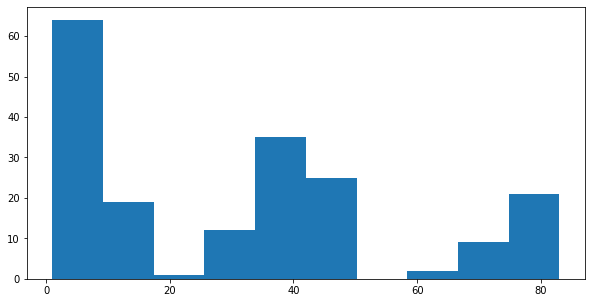

In [15]:
hist(age)

In [16]:
print(mean(age))

30.382978723404257


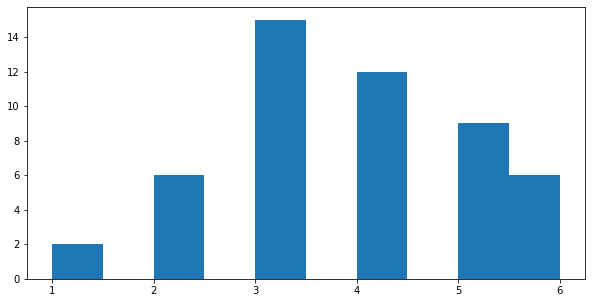

In [17]:
family_sizes = [0] * Family.count
for person in Person.people:
    family_sizes[person.family] = family_sizes[person.family] + 1

hist(family_sizes)

In [18]:
print(mean(family_sizes))

3.76


In [19]:
data = {
    'id': id,
    'age': age,
    'apartment': apartment,
    'home': home,
    'family': family,
    'office': office,
    'school': school
}
meta = pd.DataFrame(data)

## Contact Network

In [20]:
class ContactNetwork:

    def __init__(self, society):
        self.society = society
        self.timestamp = []
        self.p1 = []
        self.p2 = []
        self.time = 0

    def pick_contacts(self, pool, scale):
        n = int(len(pool) * scale)
        pool = list(pool)
        if len(pool) == 0:
            return
        for _ in range(n):
            self.p1.append(random.choice(list(pool)))
            self.p2.append(random.choice(list(pool)))
            self.timestamp.append(self.time)

    def build_contacts(self):
        for day in range(30):
            self.time = self.time + 1
            for apartment in self.society.apartments:
                self.pick_contacts(apartment.people, APARTMENT_CONTACTS_SCALE)

            self.time = self.time + 1
            for office in self.society.offices:
                self.pick_contacts(office.employees, OFFICE_CONTACTS_SCALE)
            for school in [self.society.pre, self.society.primary, self.society.secondary, self.society.college, self.society.uni]:
                self.pick_contacts(school.students, SCHOOL_CONTACTS_SCALE)

            self.time = self.time + 1
            NUM_SHOPS = Person.count // SHOP_CAPACITY + 1
            shops = [[]] * NUM_SHOPS
            for person in Person.people:
                if random.random() <= 0.4:
                    shops[random.randint(1, NUM_SHOPS) - 1].append(person.id)
            for shop in shops:
                self.pick_contacts(shop, SHOP_CONTACTS_SCALE)

            self.time = self.time + 1
            for apartment in self.society.apartments:
                for family in apartment.families:
                    self.pick_contacts(family.members, FAMILY_CONTACTS_SCALE)
            for home in self.society.homes:
                self.pick_contacts(home.family.members, FAMILY_CONTACTS_SCALE)

        data = {
            'timestamp': self.timestamp,
            'p1': self.p1,
            'p2': self.p2
        }
        cn = pd.DataFrame(data)

        return cn

In [21]:
builder = ContactNetwork(society)
cn = builder.build_contacts()

In [22]:

meta.to_csv('metadata.csv', header=True, index=False)
cn.to_csv('contact_network.csv', header=True, index=False)